In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

In [2]:
# importing dataset
dir = os.listdir("C:\\Users\\jagje\\OneDrive\\Desktop\\new plant\\PE_dataset\\PlantVillage")
for filenames in dir:
    print(filenames)

Potato___Early_blight
Potato___healthy
Potato___Late_blight


In [31]:

dataset_dir = pathlib.Path("C:\\Users\\jagje\\OneDrive\\Desktop\\new plant\\PE_dataset\\PlantVillage")
print(dataset_dir)

C:\Users\jagje\OneDrive\Desktop\new plant\PE_dataset\PlantVillage


In [32]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 40

In [33]:
#yields batches of images from the subdirectories class_a , class_b and class_c 
#together with labels 0 , 1 and 2 (0, 1, 2 corresponding to classes class_a , class_b and class_c respectively )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True) 

Found 2152 files belonging to 3 classes.


In [34]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [35]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

68

In [36]:
print(dataset) #prints Elements in dataset: here 1st element is image and 2nd index of that image.

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


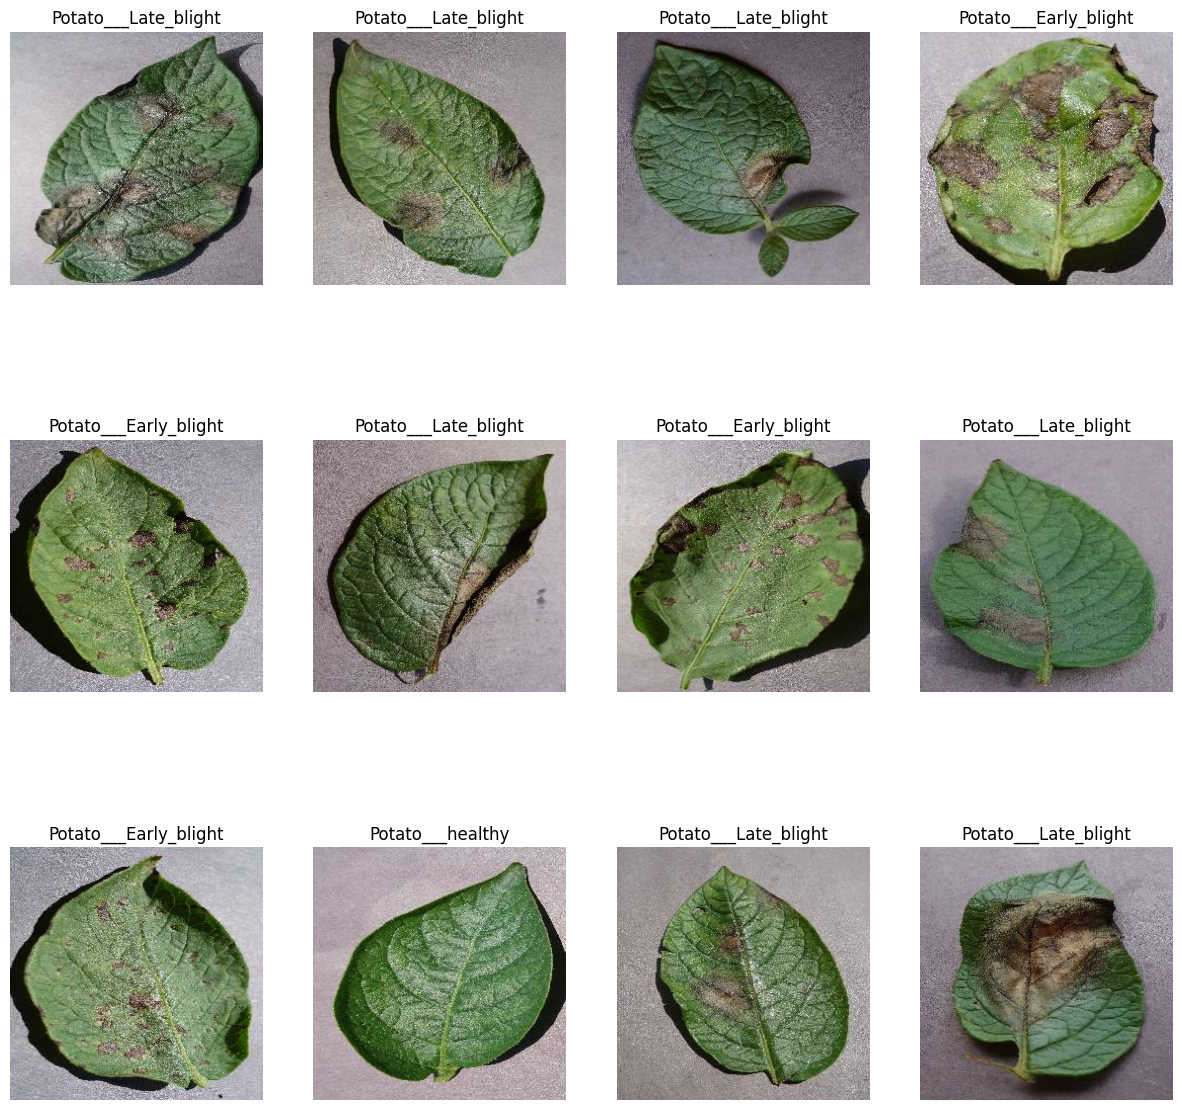

In [37]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1): 
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_name[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph

In [38]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [39]:
train_data, val_data, test_data = split_dataset(dataset)

In [40]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [41]:
# caching,shuffle and prefetching the data
train_ds = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [42]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [43]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

In [44]:
# Creating Convolution layer 
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)


In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [46]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [47]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/40
54/54 [==============================] - 132s 2s/step - loss: 1.1939 - accuracy: 0.4660 - val_loss: 0.9003 - val_accuracy: 0.4844
Epoch 2/40
54/54 [==============================] - 124s 2s/step - loss: 0.8740 - accuracy: 0.5276 - val_loss: 0.7277 - val_accuracy: 0.7656
Epoch 3/40
54/54 [==============================] - 128s 2s/step - loss: 0.6063 - accuracy: 0.7373 - val_loss: 0.6335 - val_accuracy: 0.7240
Epoch 4/40
54/54 [==============================] - 139s 3s/step - loss: 0.4178 - accuracy: 0.8286 - val_loss: 0.3898 - val_accuracy: 0.8490
Epoch 5/40
54/54 [==============================] - 128s 2s/step - loss: 0.2845 - accuracy: 0.8873 - val_loss: 0.2707 - val_accuracy: 0.8906
Epoch 6/40
54/54 [==============================] - 126s 2s/step - loss: 0.2942 - accuracy: 0.8803 - val_loss: 0.3326 - val_accuracy: 0.8393
Epoch 7/40
54/54 [==============================] - 150s 3s/step - loss: 0.2372 - accuracy: 0.9032 - val_loss: 0.2638 - val_accuracy: 0.9010
Epoch 8/40
54

In [48]:
scores = model.evaluate(train_data)

54/54 [==============================] - 58s 1s/step - loss: 0.2107 - accuracy: 0.9337


In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

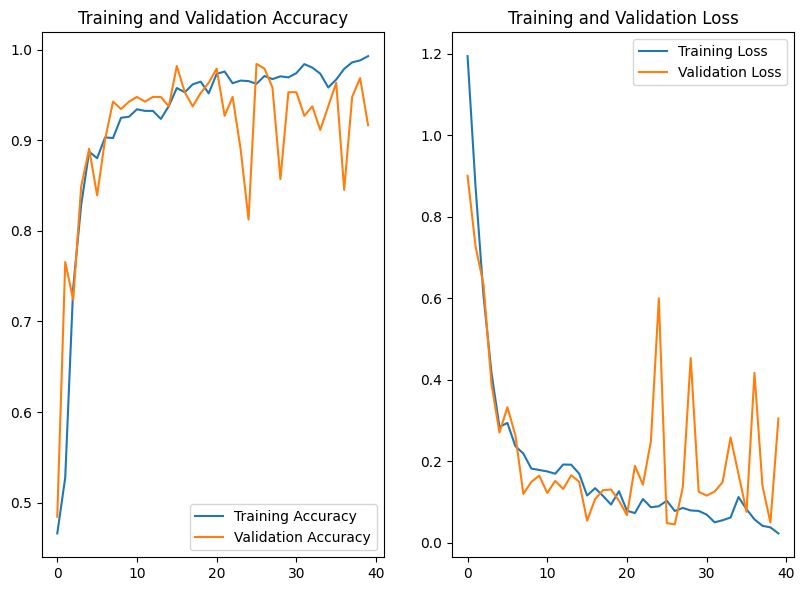

In [53]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Early_blight
1/1 [==============================] - 1s 1s/step
Predicted label :  Potato___Early_blight


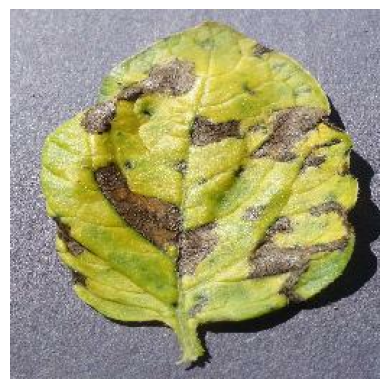

In [54]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 [==============================] - 1s 1s/step


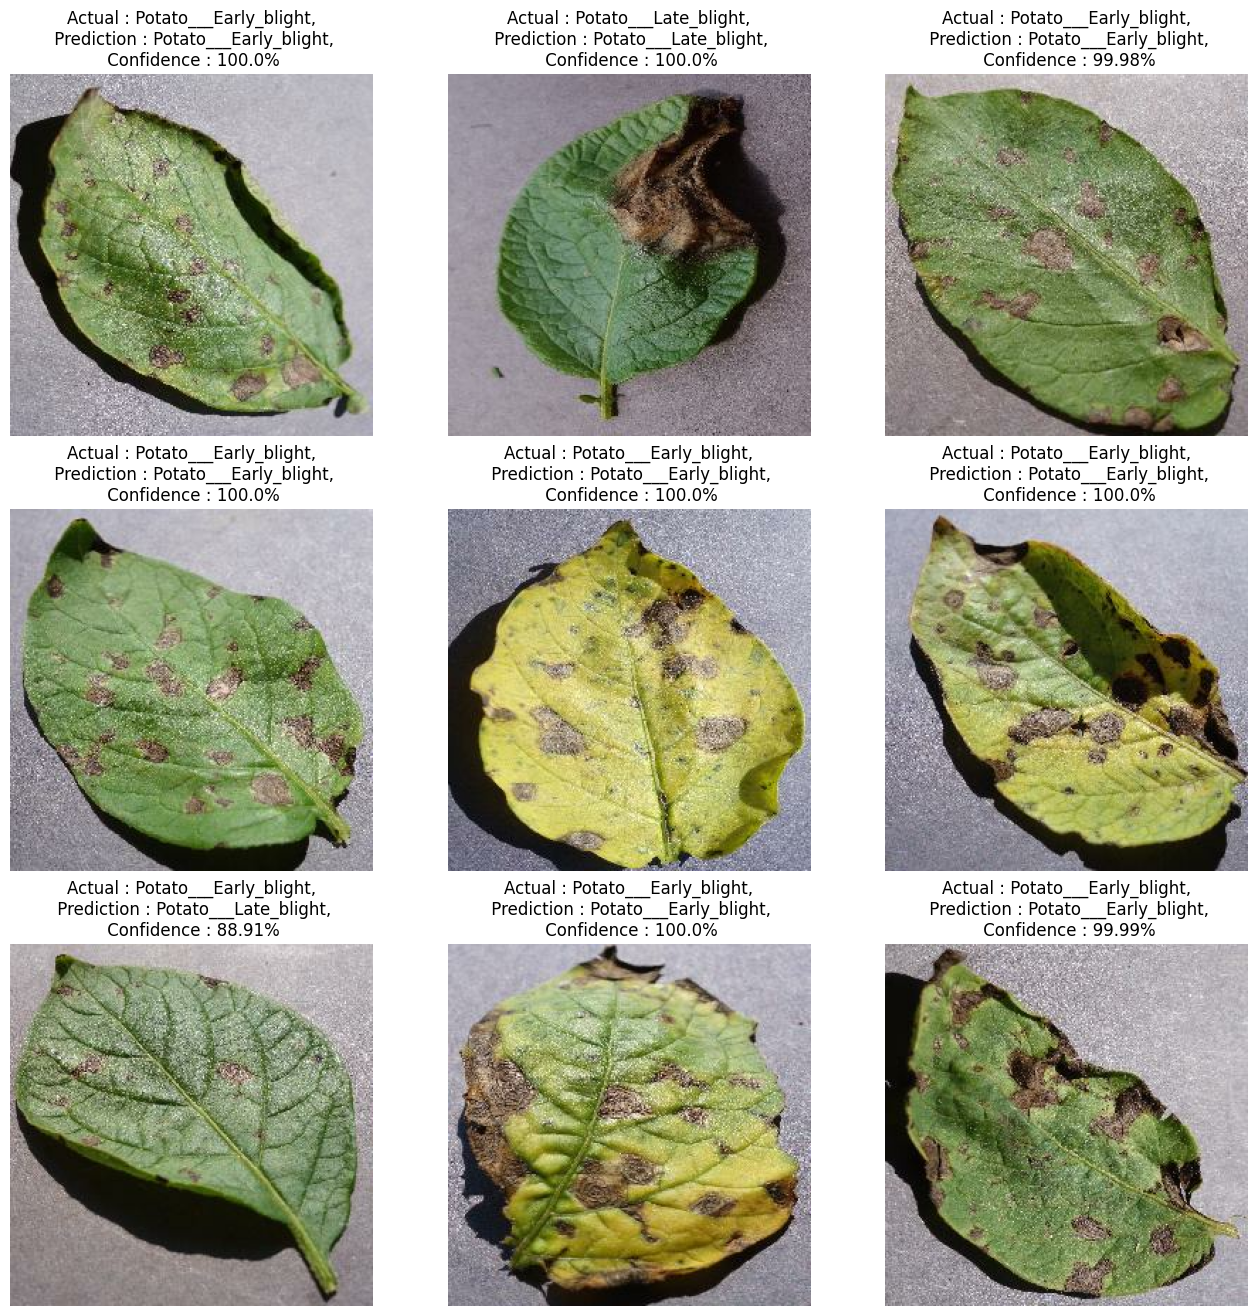

In [55]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [57]:
model.save("C:\\Users\\jagje\\OneDrive\\Desktop\\new plant\\final_model.h5")